In [1]:
import duckdb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Step 1: Load data from DuckDB
con = duckdb.connect("/Users/koosha/00-My Files-00/My Works/GitHub/Repositories/BNPL_Customer_Data/BNPL_customer_data/dev.duckdb", read_only=True)
df = con.execute("SELECT * FROM stg_BNPL_customer").fetchdf()


In [3]:
# Step 2: Prepare features
df = df.copy()
df['app_version'] = df['app_version'].astype(str)
df['app_version_encoded'] = df['app_version'].astype('category').cat.codes

features = [
    'age', 'avg_monthly_revenue', 'bnpl_amount', 'month_id',
    #'repayment_days_delay', --removed as it has direct relation with target feature
    'bnpl_repeat_count',
    'direct_channel_usage_share', 'recent_recharge_freq',
    'bundle_purchase_count', 'app_version_encoded'
]

X = df[features]
y = df['bnpl_default']


In [ ]:
# Balancing Step

df_balanced = df[df['bnpl_default'].isin([0,1])]  # remove if multi-class
minority_size = df_balanced['bnpl_default'].value_counts().min()

df_class_0 = df_balanced[df_balanced['bnpl_default'] == 0].sample(minority_size, random_state=42)
df_class_1 = df_balanced[df_balanced['bnpl_default'] == 1].sample(minority_size, random_state=42)

df_balanced = pd.concat([df_class_0, df_class_1]).sample(frac=1, random_state=42).reset_index(drop=True)

X = df_balanced[features]
y = df_balanced['bnpl_default']

In [5]:
# Step 3: Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [6]:
# Step 4: Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [7]:
# Step 5: Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.75      0.55      0.63       275
           1       0.67      0.83      0.74       298

    accuracy                           0.70       573
   macro avg       0.71      0.69      0.69       573
weighted avg       0.71      0.70      0.69       573



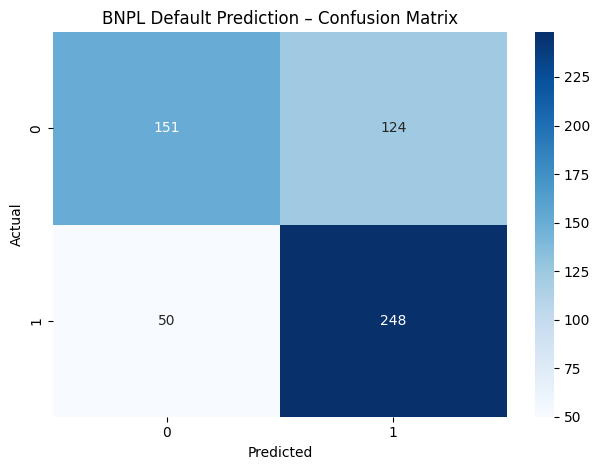

In [8]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("BNPL Default Prediction – Confusion Matrix")
plt.tight_layout()
plt.savefig("../results/confusion_matrix.png")
plt.show()

In [10]:
#Show top 10 features
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top 10 important features:")
print(importances.head(10))

Top 10 important features:
bnpl_amount                   0.348875
avg_monthly_revenue           0.142093
direct_channel_usage_share    0.132821
age                           0.111914
recent_recharge_freq          0.062036
bnpl_repeat_count             0.061073
bundle_purchase_count         0.053740
month_id                      0.047642
app_version_encoded           0.039806
dtype: float64
